5


Text(0.5, 1.0, 'tulips')

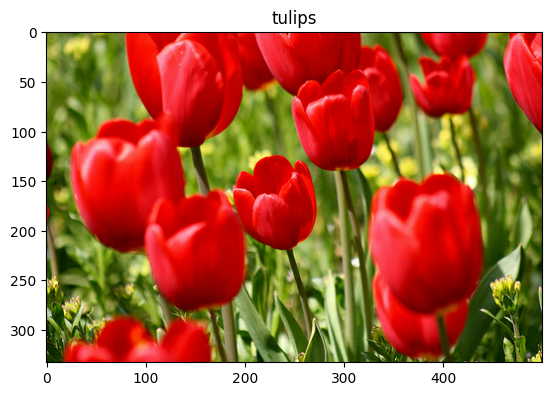

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', #name of dataset from tf to load
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], #split train
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes) #the flowers dataset has 5 classes

get_label_name = metadata.features['label'].int2str #Metadata describes the source and quality of the entity data contained in a dataset

image, label = next(iter(train_ds)) #chooses the first photo in the dataset
plt.imshow(image) #shows the image
plt.title(get_label_name(label)) #gives the title tulips

In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'trash_ai_training_photos',
    labels = 'inferred',
    label_mode = "categorical",
    class_names = ['Paper', 'Plastic', 'Regular_Trash'],
    color_mode = "rgb",
    batch_size = 2, #num samples processed before model is updated
#     image_size = ,
    shuffle = True,
    seed = 123,
    #subset = "training"
)

# num_classes = metadata.features['label'].num_classes
# print(num_classes)

def augment(image, label):
    #to change the height and width of the image
    new_height = 32
    new_width = 32
    image = tf.image.resize(image, (new_height, new_width))
    
    #to convert the image to grayscale
    image = tf.image.rgb_to_grayscale(image)

ds_train = ds_train.map(augment)

print(ds_train)


Found 1 files belonging to 3 classes.


InvalidArgumentError: Length for attr 'output_shapes' of 0 must be at least minimum 1
	; NodeDef: {{node MapDataset}}; Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=metadata:string,default=""> [Op:MapDataset]

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

directory = 'trash_ai_annotated_photos' #directory with annotated photos
df = pd.read_csv(directory + '\annotations.csv') #directory of csv file

#files should be named label_index
file_paths = df['file_name'].values #for example: plastic_1.jpg
#print(file_paths)

labels = df['name'].values #column in csv called name which is what we labeled the object in photo
#first value of filepath is equal to the label of the first element, maps everything together
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))

def read_image(image_file, label):
    image = tf.io.read_file(directory + image_file) #read the image file
    image = tf.image.decode_image(image, dtype=tf.float32) #detects what kind of image it is (JPEG, PNG, etc.) and converts it to a Tensor of type dtype
    return image, label

def augment(image, label)
    #to change the height and width of the image
    new_height = 32
    new_width = 32
    image = tf.image.resize(image, (new_height, new_width))
    
    #to convert the image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    return image, label

ds_train = ds_train.map(read_image).map(augment).batch(2)
#batch (2) = num samples processed before model is updated